#Install Libraries

In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install pandas_ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218921 sha256=83b6272b5d49c2f4f01ce2085e2d749d41de75779f02690586ce8b9fa122497e
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [ ]:
#Import utility
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Import data import libraries
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr
import pandas_ta as pta

#Import data preprocessing libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#Import DL libraries
from tensorflow.keras.layers import Dense, LSTM,GRU,SimpleRNN, Dropout,Bidirectional, Input, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Import Data

In [ ]:
df = pdr.get_data_yahoo("IBM", start="1980-02-01", end="2019-07-13")

[*********************100%***********************]  1 of 1 completed


#Feature Selection

##What aer the different features we can use, keep in mind we want to solve the problem of scaling and predict tomorrow's price

**So what is the problem with scaling using minmaxscaler or standard scaler on general problems? **

-> If we fit the scaler on Nifty data which ranges from (4000 to 11000), the newer stock values when transformed will have very low values (less pattern similarity corresponding to only 20% of initial training dataset).


**What if we use different scalers?**

-> Even if we use different scalers,

  -> There is a problem of data not being normalized. The patterns in the chart will range from 0-0.3 (for first 20% data) and so on, be divided into brackets.

**So we conclude we need to normalize the data. As we are only using univariate feature, what do you propose? **

-> I propose 2 solutions,
  
  -> Create batches using unscaled data. Then scale the data on the individual batches. Handling only a single feature makes this task simpler as we can create batches with the targets, scale them, and then seperate them. We have 2 options for scaling, 1 would be use a standard scaler but in that case, we would have to store all the scalers (equal to the number of batches). What we can do instead is scale it ourselves using mean and std dv and store these values in a dictionary against batch number so original value can be retrieved after transformation. I will try the standardscaling function to check the mse, in my opinion it should perform better and give a lower mse value.

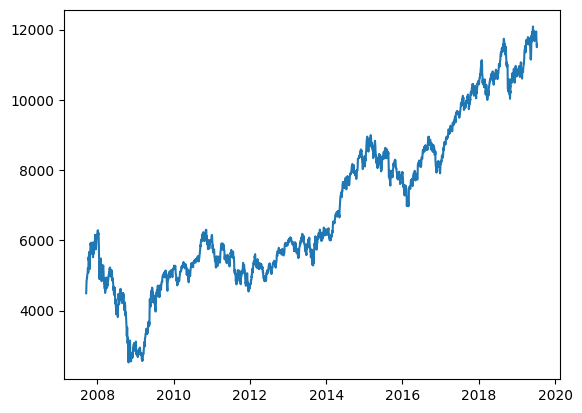

In [ ]:
plt.plot(df['Close'])

#Unconventional method of scaling

##Create Targets and scale the data

The target is going to be next day's closing price. The batches will be create accordingly.

In [ ]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-02-01,16.401770,16.610899,16.342016,16.581022,4.950256,1513353
1980-02-04,16.581022,16.640774,16.401770,16.521273,4.932416,1205829
1980-02-05,16.521273,16.640774,16.431644,16.640774,4.968094,1595778
1980-02-06,16.491396,16.491396,16.192638,16.342016,4.939920,2133003
1980-02-07,16.312141,16.312141,16.043261,16.043261,4.849609,2145555
...,...,...,...,...,...,...
2019-07-08,134.847031,135.076477,134.101334,134.388138,111.771950,2505484
2019-07-09,134.426392,134.789673,133.011475,133.202682,110.786003,3519999
2019-07-10,133.843216,135.669220,133.642441,134.292542,111.692467,2629539


In [ ]:
feature = np.array(df['Open'])

print(feature.shape)

import math

training_data_len = math.ceil(feature.shape[0] *0.8)
print(training_data_len)
training_data = feature[:training_data_len]
testing_data = feature[training_data_len:]
print(training_data.shape, testing_data.shape)

(9946,)
7957
(7957,) (1989,)


In [ ]:
batches = []

for i in range(30,len(training_data)):
    buffer_array = list(training_data[i-30:i])
    buffer_array.append(training_data[i])
    batches.append(buffer_array)

print(np.array(batches).shape)

(7927, 31)


In [ ]:
len(batches)

7927

In [ ]:
#Define batch scaling function
scaled_data = []

def scale(x):
  seq_x = list(x[:-1])
  max_x = max(seq_x)
  min_x = min(seq_x)
  new_seq = []
  for j in seq_x:
    new_j = (j-min_x)/(max_x-min_x)
    new_seq.append(new_j)
  new_seq.append((x[-1]-min_x)/(max_x-min_x))
  return new_seq

for i in range(0, len(batches)):
  seq = batches[i]
  new_seq = scale(seq)
  scaled_data.append(new_seq)

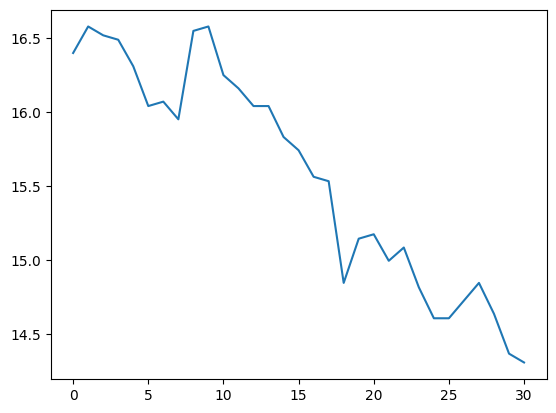

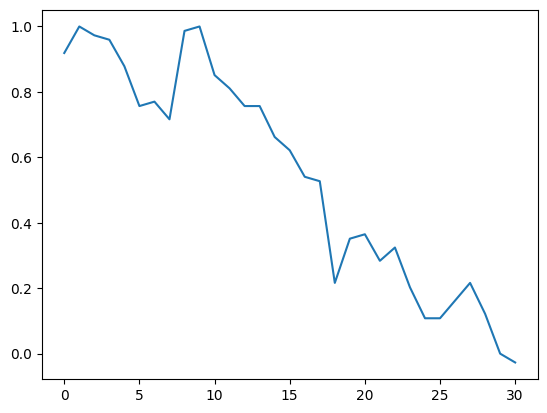

In [ ]:
plt.plot(np.array(batches)[0])
plt.show()
plt.plot(np.array(scaled_data)[0])
plt.show()


In [ ]:
np.array(scaled_data).shape

x_train = []
y_train = []
for i in range(0, len(scaled_data)):
    seq = scaled_data[i]
    x_train.append(seq[0:-1])
    y_train.append(seq[-1])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape, y_train.shape)

(7927, 30, 1) (7927,)


##Model Architecture

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
## epochs = 9
history = model.fit(x_train, y_train, batch_size=256, epochs=50, validation_split=0.2)

Epoch 1/50
25/25 [==============================] - 12s 237ms/step - loss: 0.1675 - val_loss: 0.0984
Epoch 2/50
25/25 [==============================] - 4s 167ms/step - loss: 0.0834 - val_loss: 0.0710
Epoch 3/50
25/25 [==============================] - 6s 233ms/step - loss: 0.0623 - val_loss: 0.0632
Epoch 4/50
25/25 [==============================] - 5s 208ms/step - loss: 0.0554 - val_loss: 0.0578
Epoch 5/50
25/25 [==============================] - 5s 200ms/step - loss: 0.0499 - val_loss: 0.0514
Epoch 6/50
25/25 [==============================] - 3s 137ms/step - loss: 0.0446 - val_loss: 0.0457
Epoch 7/50
25/25 [==============================] - 3s 135ms/step - loss: 0.0388 - val_loss: 0.0373
Epoch 8/50
25/25 [==============================] - 5s 189ms/step - loss: 0.0333 - val_loss: 0.0354
Epoch 9/50
25/25 [==============================] - 4s 144ms/step - loss: 0.0319 - val_loss: 0.0309
Epoch 10/50
25/25 [==============================] - 3s 136ms/step - loss: 0.0297 - val_loss: 0.028

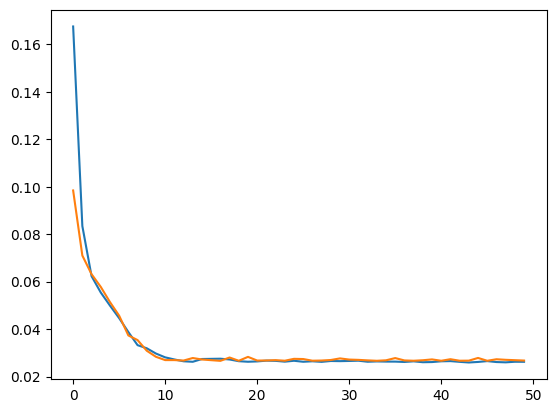

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

##Creating testing batches

In [ ]:
testing_batches = []

for i in range(30,len(testing_data)):
    buffer_array = list(testing_data[i-30:i])
    buffer_array.append(testing_data[i])
    testing_batches.append(buffer_array)

print(np.array(testing_batches).shape)

(1959, 31)


In [ ]:
#Define batch scaling function
scaled_testing_data = []

scaling_dict = {}
def inverse_scale(x, min_x, max_x):
  orig_seq = []
  for j in x:
    orig_j = j*(max_x-min_x) + min_x
    orig_seq.append(orig_j)
  return orig_seq

def scale(x, i):
  seq_x = list(x[:-1])
  max_x = max(seq_x)
  min_x = min(seq_x)
  scaling_dict[i] = (min_x, max_x)
  new_seq = []
  for j in seq_x:
    new_j = (j-min_x)/(max_x-min_x)
    new_seq.append(new_j)
  new_seq.append((x[-1]-min_x)/(max_x-min_x))
  return new_seq

for i in range(0, len(testing_batches)):
  seq = testing_batches[i]
  new_seq = scale(seq, i)
  scaled_testing_data.append(new_seq)

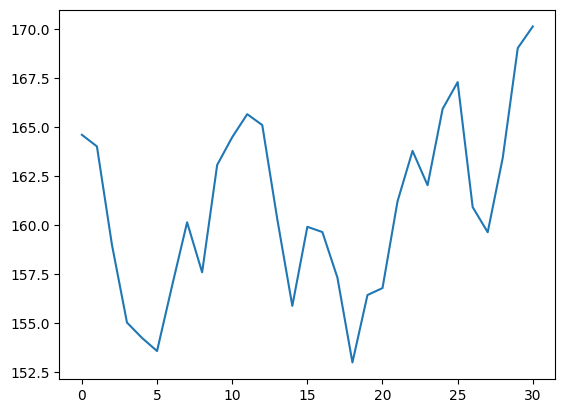

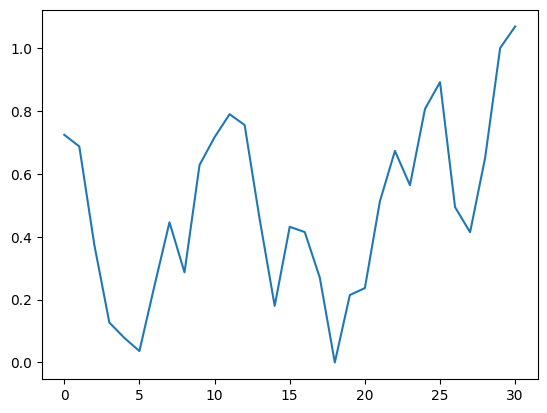

In [ ]:
plt.plot(np.array(testing_batches)[0])
plt.show()
plt.plot(np.array(scaled_testing_data)[0])
plt.show()


In [ ]:
# dict_values = list(scaling_dict[0])

# or_seq = inverse_scale(scaled_testing_data[0], dict_values[0], dict_values[1])
# plt.plot(np.array(testing_batches)[0])
# plt.show()
# plt.plot(or_seq)
# plt.show()

In [ ]:
x_test = []
y_test = []
for i in range(0, len(scaled_testing_data)):
    seq = scaled_testing_data[i]
    x_test.append(seq[0:-1])
    y_test.append(seq[-1])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_test.shape, y_test.shape)

(1959, 30, 1) (1959,)


##Testing

In [ ]:
model.evaluate(x_test, y_test)

62/62 [==============================] - 1s 11ms/step - loss: 0.0298


0.029796725139021873

In [ ]:
prediction_list = model.predict(x_test)


62/62 [==============================] - 2s 11ms/step


In [ ]:
transformed_prediction_list = []

for i in range(0,len(prediction_list)):
    dict_values = list(scaling_dict[i])
    or_seq = inverse_scale(prediction_list[i], dict_values[0], dict_values[1])
    transformed_prediction_list.append(or_seq)

1959 1959


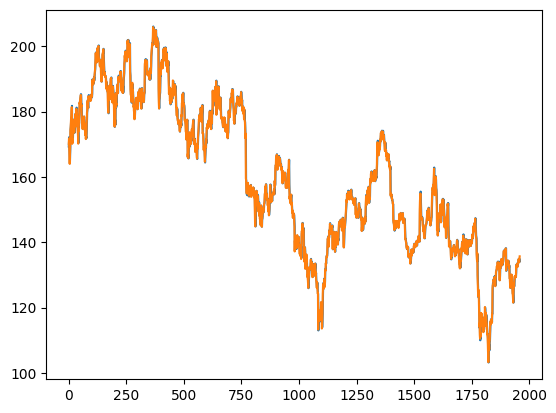

In [ ]:
print(len(transformed_prediction_list), len(testing_data[30:]))
plt.plot(transformed_prediction_list)
plt.plot(testing_data[30:])

In [ ]:
transformed_prediction_list = np.array(transformed_prediction_list)
testing_data_np = np.array(testing_data[30:])

print(transformed_prediction_list.shape, testing_data_np.shape)
error = 0
for i in range(0,len(testing_data_np)):
  buffer_error = math.sqrt((transformed_prediction_list[i] - testing_data_np[i])*(transformed_prediction_list[i] - testing_data_np[i]))
  error += buffer_error

print("Final rmse: ", error/len(testing_data_np))

(1959, 1) (1959,)
Final rmse:  1.2934291995496094


##Testing on IGL

In [ ]:
df_IGL = pdr.get_data_yahoo("IGL.NS", start="1980-02-01", end="2019-07-13")

[*********************100%***********************]  1 of 1 completed


In [ ]:
feature_igl = df_IGL['Open']
print(feature_igl.shape)

(3847,)


In [ ]:
testing_batches = []

for i in range(30,len(feature_igl)):
    buffer_array = list(feature_igl[i-30:i])
    buffer_array.append(feature_igl[i])
    testing_batches.append(buffer_array)

print(np.array(testing_batches).shape)

(3817, 31)


In [ ]:
#Define batch scaling function
scaled_testing_data = []

scaling_dict = {}
def inverse_scale(x, min_x, max_x):
  orig_seq = []
  for j in x:
    orig_j = j*(max_x-min_x) + min_x
    orig_seq.append(orig_j)
  return orig_seq

def scale(x, i):
  seq_x = list(x[:-1])
  max_x = max(seq_x)
  min_x = min(seq_x)
  scaling_dict[i] = (min_x, max_x)
  new_seq = []
  for j in seq_x:
    new_j = (j-min_x)/(max_x-min_x)
    new_seq.append(new_j)
  new_seq.append((x[-1]-min_x)/(max_x-min_x))
  return new_seq

for i in range(0, len(testing_batches)):
  seq = testing_batches[i]
  new_seq = scale(seq, i)
  scaled_testing_data.append(new_seq)

In [ ]:
x_test = []
y_test = []
for i in range(0, len(scaled_testing_data)):
    seq = scaled_testing_data[i]
    x_test.append(seq[0:-1])
    y_test.append(seq[-1])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_test.shape, y_test.shape)

(3817, 30, 1) (3817,)


In [ ]:
prediction_list = model.predict(x_test)


120/120 [==============================] - 2s 14ms/step


In [ ]:
transformed_prediction_list = []

for i in range(0,len(prediction_list)):
    dict_values = list(scaling_dict[i])
    or_seq = inverse_scale(prediction_list[i], dict_values[0], dict_values[1])
    transformed_prediction_list.append(or_seq)

3817 3817


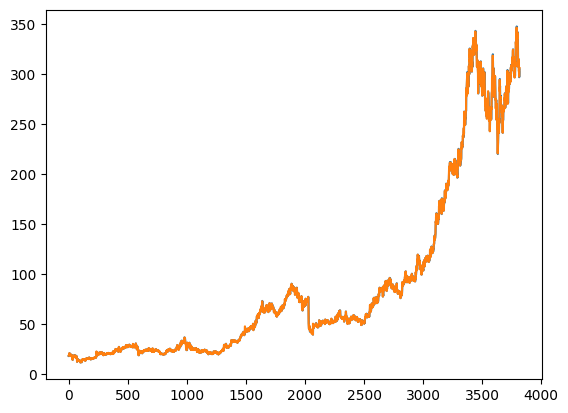

In [ ]:
print(len(transformed_prediction_list), len(feature_igl[30:]))
plt.plot(np.array(transformed_prediction_list))
plt.plot(np.array(feature_igl[30:]))

In [ ]:
transformed_prediction_list = np.array(transformed_prediction_list)
testing_data_np = np.array(feature_igl[30:])

print(transformed_prediction_list.shape, testing_data_np.shape)
error = 0
for i in range(0,len(testing_data_np)):
  buffer_error = math.sqrt((transformed_prediction_list[i] - testing_data_np[i])*(transformed_prediction_list[i] - testing_data_np[i]))
  error += buffer_error

print("Final rmse: ", error/len(testing_data_np))

(3817, 1) (3817,)
Final rmse:  1.3884208299498022


##Check tomorrow's prediction

In [ ]:
last_30 = scale(feature_igl[-30:], 0)
print(len(last_30))

30


In [ ]:
last_30_reshape = np.array(last_30).reshape(1,30,1)

In [ ]:
prediction = model.predict(last_30_reshape)

1/1 [==============================] - 0s 45ms/step


In [ ]:
dict_values = scaling_dict[0]
pred = inverse_scale(prediction, dict_values[0], dict_values[1])

In [ ]:
pred

[array([310.43127], dtype=float32)]

##Check how accurate regression is

In [ ]:
preds, actual_close = pd.DataFrame(np.array(transformed_prediction_list)), pd.DataFrame(np.array(feature_igl[30:]))

In [ ]:
dataframe = pd.concat([preds, actual_close], axis=1)

In [ ]:
dataframe.columns = ['preds', 'actual_close']
dataframe

,preds,actual_close
0,17.934000,18.320000
1,18.130085,18.500000
2,18.323489,18.889999
3,18.704950,18.799999
4,18.682460,19.959999
...,...,...
3812,296.297332,297.100006
3813,295.942539,303.899994
3814,302.536634,304.299988
3815,303.193434,305.799988


In [ ]:
fp = 0
fn = 0
tn = 0
tp = 0

for i in range(0, dataframe.shape[0]-1):
    if dataframe.iloc[i+1][0] > dataframe.iloc[i][1] and dataframe.iloc[i+1][1]>dataframe.iloc[i][1]:
        tp += 1
    elif dataframe.iloc[i+1][0] > dataframe.iloc[i][1] and dataframe.iloc[i+1][1]<dataframe.iloc[i][1]:
        fp += 1
    elif dataframe.iloc[i+1][0] < dataframe.iloc[i][1] and dataframe.iloc[i+1][1]<dataframe.iloc[i][1]:
        tn += 1
    elif dataframe.iloc[i+1][0] < dataframe.iloc[i][1] and dataframe.iloc[i+1][1]>dataframe.iloc[i][1]:
        fn += 1

In [ ]:
print(tp, tn, fp, fn)

92 1780 93 1811


#Conventional method of scaling, where you scale the entire dataset

In [ ]:
feature = df['Close']
print(feature.shape)

(2889,)


##Scale the data

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import math

training_data_len = math.ceil(feature.shape[0] *0.8)
print(training_data_len)
training_data = feature[:training_data_len]
testing_data = feature[training_data_len:]
print(training_data.shape, testing_data.shape)
scaler = MinMaxScaler()
scaled_training_data = scaler.fit_transform(np.reshape(np.array(training_data), (np.array(training_data).shape[0], 1)))
print("shape of scaled data: ", scaled_training_data.shape)


2312
(2312,) (577,)
shape of scaled data:  (2312, 1)


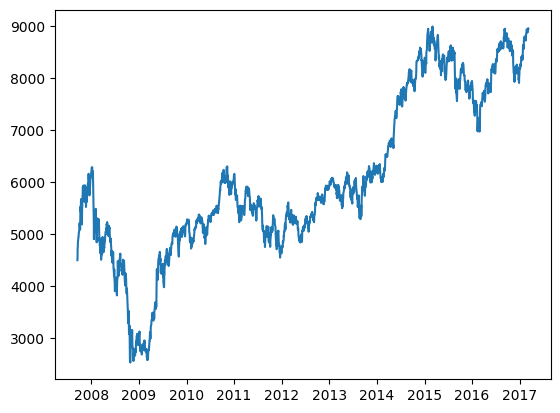

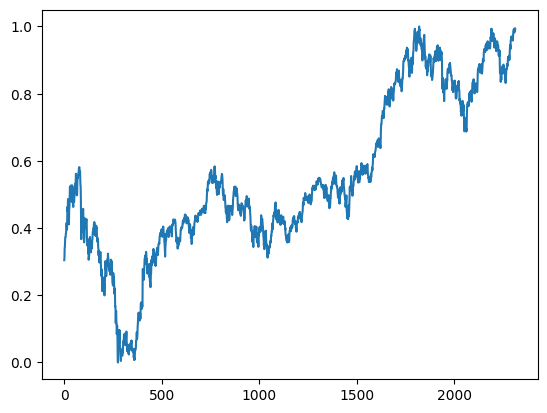

In [ ]:
plt.plot(training_data)
plt.show()
plt.plot(scaled_training_data)
plt.show()

##Create batches

In [ ]:
x_train =[]
y_train = []
for i in range(30,len(scaled_training_data)):
    x_train.append(scaled_training_data[i-30:i,0])
    y_train.append(scaled_training_data[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape, y_train.shape

((2282, 30, 1), (2282,))

##Model Architecture and training

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
## epochs = 9
history = model.fit(x_train, y_train, batch_size=256, epochs=20, validation_split=0.2)

Epoch 1/20
8/8 [==============================] - 8s 246ms/step - loss: 0.1248 - val_loss: 0.0504
Epoch 2/20
8/8 [==============================] - 1s 192ms/step - loss: 0.0201 - val_loss: 0.0656
Epoch 3/20
8/8 [==============================] - 2s 236ms/step - loss: 0.0144 - val_loss: 0.0253
Epoch 4/20
8/8 [==============================] - 1s 127ms/step - loss: 0.0055 - val_loss: 0.0010
Epoch 5/20
8/8 [==============================] - 1s 116ms/step - loss: 0.0041 - val_loss: 0.0147
Epoch 6/20
8/8 [==============================] - 1s 116ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 7/20
8/8 [==============================] - 1s 111ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 8/20
8/8 [==============================] - 1s 114ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 9/20
8/8 [==============================] - 1s 115ms/step - loss: 9.5723e-04 - val_loss: 9.2388e-04
Epoch 10/20
8/8 [==============================] - 1s 116ms/step - loss: 8.8629e-04 - val_loss: 8.3656e-04
Epo

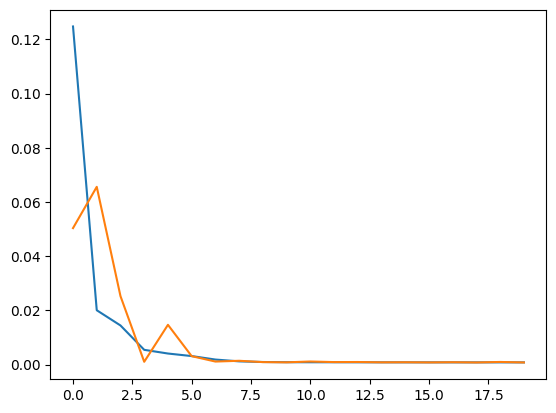

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

##Create testing batches

In [ ]:
scaled_testing_data = scaler.transform(np.reshape(np.array(testing_data), (np.array(testing_data).shape[0], 1)))
print(scaled_testing_data.shape)

(577, 1)


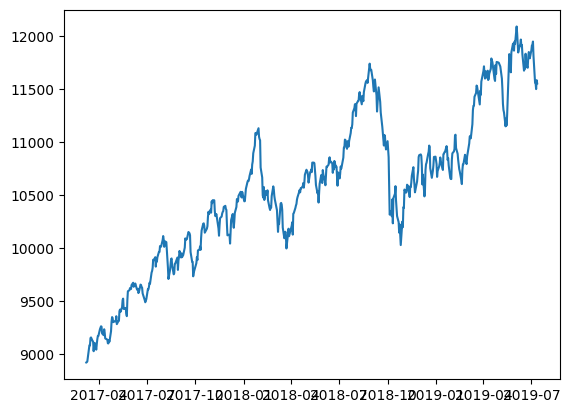

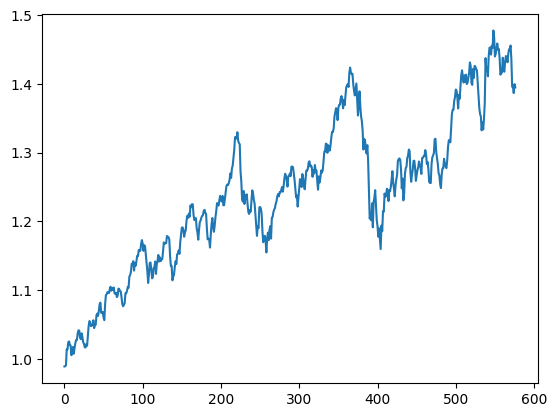

In [ ]:
plt.plot(testing_data)
plt.show()

plt.plot(scaled_testing_data)
plt.show()

In [ ]:
x_test =[]
y_test = []
for i in range(30,len(scaled_testing_data)):
    x_test.append(scaled_testing_data[i-30:i,0])
    y_test.append(scaled_testing_data[i,0])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
x_test.shape, y_test.shape

((547, 30, 1), (547,))

In [ ]:
model.evaluate(x_test, y_test)

18/18 [==============================] - 0s 17ms/step - loss: 0.0015


0.001517165219411254

In [ ]:
prediction_list = model.predict(x_test)


18/18 [==============================] - 1s 12ms/step


In [ ]:
transformed_pred_list = scaler.inverse_transform(prediction_list)
transformed_pred_list.shape, testing_data.shape

((547, 1), (577,))

Actual error calculated using the real world data after inversely transforming the predictions

In [ ]:
transformed_pred_list = np.array(transformed_pred_list).flatten()
testing_data_np = np.array(testing_data[30:])

print(transformed_pred_list.shape, testing_data_np.shape)
error = 0
for i in range(0,len(testing_data_np)):
  buffer_error = math.sqrt((transformed_pred_list[i] - testing_data_np[i])*(transformed_pred_list[i] - testing_data_np[i]))
  error += buffer_error

print("Final rmse: ", error/len(testing_data_np))

(547,) (547,)
Final rmse:  209.05028314956581


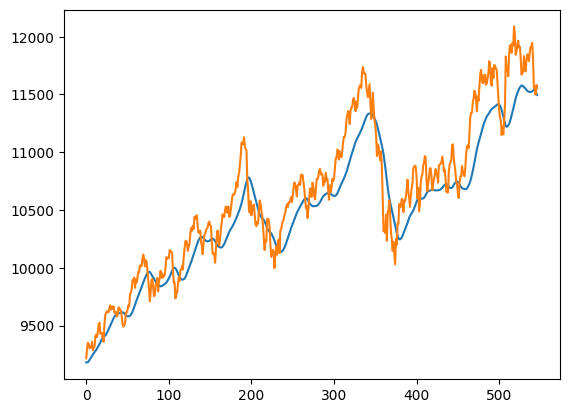

In [ ]:
plt.plot(transformed_pred_list)
plt.plot(np.array(testing_data)[30:])
plt.show()

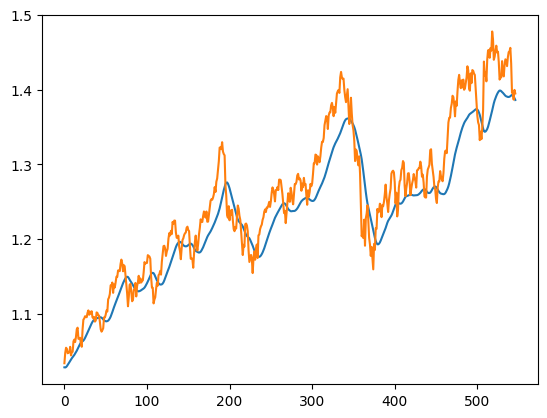

In [ ]:
plt.plot(prediction_list)
plt.plot(y_test)
plt.show()

##To check how it performs on IGL data, ie can it generalize well?

In [ ]:
df_IGL = pdr.get_data_yahoo("IGL.NS", start="1980-02-01", end="2019-07-13")

[*********************100%***********************]  1 of 1 completed


In [ ]:
feature_igl = df_IGL['Close']
print(feature_igl.shape)

scaled_feature_igl = scaler.transform(np.reshape(np.array(feature_igl), (feature_igl.shape[0], 1)))

(3847,)


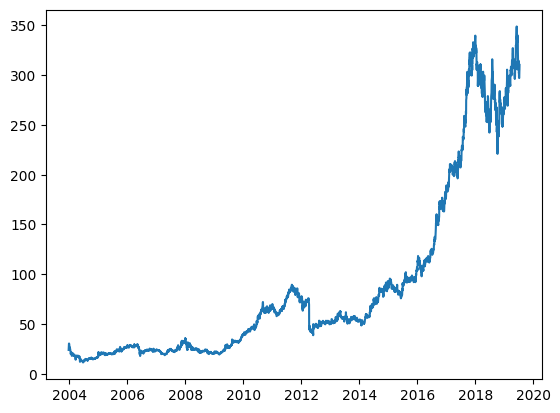

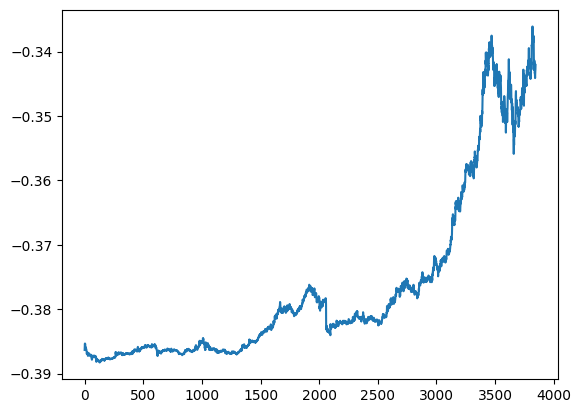

In [ ]:
plt.plot(feature_igl)
plt.show()
plt.plot(scaled_feature_igl)
plt.show()

In [ ]:
x_test =[]
y_test = []
for i in range(30,len(scaled_feature_igl)):
    x_test.append(scaled_feature_igl[i-30:i,0])
    y_test.append(scaled_feature_igl[i,0])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
x_test.shape, y_test.shape

((3817, 30, 1), (3817,))

In [ ]:
prediction_list = model.predict(x_test)

120/120 [==============================] - 2s 15ms/step


In [ ]:
print(prediction_list.shape, y_test.shape)

(3817, 1) (3817,)


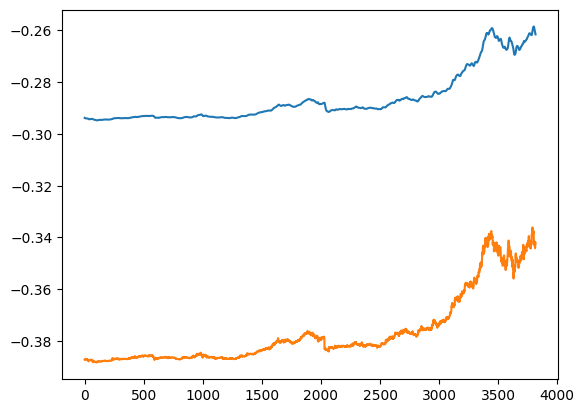

In [ ]:
plt.plot(prediction_list)
plt.plot(y_test)

In [ ]:
transformed_pred_list = scaler.inverse_transform(prediction_list)
print(transformed_pred_list.shape)

(3817, 1)


In [ ]:
transformed_pred_list = np.array(transformed_pred_list).flatten()
testing_data_np = np.array(feature_igl[30:])

print(transformed_pred_list.shape, testing_data_np.shape)
error = 0
for i in range(0,len(testing_data_np)):
  buffer_error = math.sqrt((transformed_pred_list[i] - testing_data_np[i])*(transformed_pred_list[i] - testing_data_np[i]))
  error += buffer_error

print("Final rmse: ", error/len(testing_data_np))

(3817,) (3817,)
Final rmse:  582.6881814618869


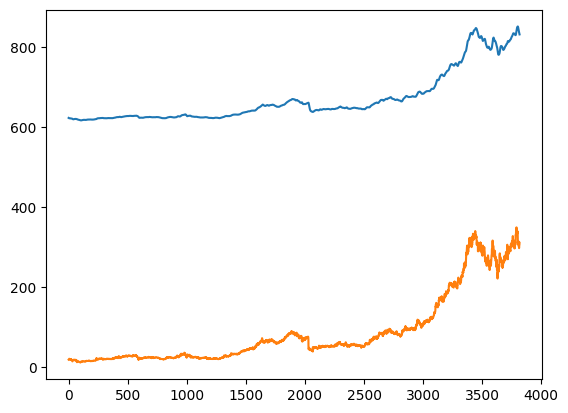

In [ ]:
plt.plot(transformed_pred_list)
plt.plot(testing_data_np)

#Check classification based on intrabatch scaled data

##Create Targets and scale the data

The target is going to be next day's closing price. The batches will be create accordingly.

In [ ]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902,4494.649902,0
2007-09-18,4494.100098,4551.799805,4481.549805,4546.200195,4546.200195,0
2007-09-19,4550.250000,4739.000000,4550.250000,4732.350098,4732.350098,0
2007-09-20,4734.850098,4760.850098,4721.149902,4747.549805,4747.549805,0
2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805,4837.549805,0
...,...,...,...,...,...,...
2019-07-08,11770.400391,11771.900391,11523.299805,11558.599609,11558.599609,464000
2019-07-09,11531.599609,11582.549805,11461.000000,11555.900391,11555.900391,442500
2019-07-10,11536.150391,11593.700195,11475.650391,11498.900391,11498.900391,337600


In [ ]:
feature = np.array(df['Close'])

print(feature.shape)

import math

training_data_len = math.ceil(feature.shape[0] *0.8)
print(training_data_len)
training_data = feature[:training_data_len]
testing_data = feature[training_data_len:]
print(training_data.shape, testing_data.shape)

(2889,)
2312
(2312,) (577,)


In [ ]:
batches = []

for i in range(30,len(training_data)):
    buffer_array = list(training_data[i-30:i])
    if training_data[i] > training_data[i-1]:
        buffer_array.append(1)
    else:
        buffer_array.append(-1)

    batches.append(buffer_array)
print(np.array(batches).shape)

(2282, 31)


In [ ]:
#Define batch scaling function
scaled_data = []

def scale(x):
  seq_x = list(x[:-1])
  max_x = max(seq_x)
  min_x = min(seq_x)
  new_seq = []
  for j in seq_x:
    new_j = (j-min_x)/(max_x-min_x)
    new_seq.append(new_j)
  new_seq.append(x[-1])
  return new_seq

for i in range(0, len(batches)):
  seq = batches[i]
  new_seq = scale(seq)
  scaled_data.append(new_seq)

In [ ]:
print(np.array(batches)[0], np.array(scaled_data)[0])

[ 4.4946499e+03  4.5462002e+03  4.7323501e+03  4.7475498e+03
  4.8375498e+03  4.9322002e+03  4.9388501e+03  4.9405000e+03
  5.0005498e+03  5.0213501e+03  5.0689502e+03  5.2107998e+03
  5.2086499e+03  5.1858501e+03  5.0851001e+03  5.3272500e+03
  5.4414502e+03  5.5248501e+03  5.4282500e+03  5.6703999e+03
  5.6680498e+03  5.5592998e+03  5.3510000e+03  5.2152998e+03
  5.1840000e+03  5.4737002e+03  5.4961499e+03  5.5689502e+03
  5.7022998e+03  5.9058999e+03 -1.0000000e+00] [ 0.          0.03652811  0.16843238  0.17920277  0.24297602  0.31004449
  0.31475656  0.31592567  0.35847646  0.37321537  0.40694441  0.50745786
  0.50593446  0.4897787   0.41838809  0.5899735   0.6708948   0.72999128
  0.66154126  0.83312666  0.8314614   0.75440206  0.60680255  0.51064652
  0.48846774  0.69374689  0.70965456  0.76124024  0.85573067  1.
 -1.        ]


In [ ]:
plt.plot(np.array(batches)[0])
plt.show()
plt.plot(np.array(scaled_data)[0])
plt.show()


In [ ]:
np.array(scaled_data).shape

x_train = []
y_train = []
for i in range(0, len(scaled_data)):
    seq = scaled_data[i]
    x_train.append(seq[0:-1])
    y_train.append(seq[-1])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape, y_train.shape)

(2282, 30, 1) (2282,)


##Model Architecture

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25, activation='tanh'))
model.add(Dense(units=1, activation='tanh'))

model.compile(optimizer='adam', loss='binary_crossentropy')
## epochs = 9
history = model.fit(x_train, y_train, batch_size=256, epochs=20, validation_split=0.2)

Epoch 1/20
8/8 [==============================] - 9s 245ms/step - loss: 0.5624 - val_loss: 0.4388
Epoch 2/20
8/8 [==============================] - 1s 124ms/step - loss: 0.5663 - val_loss: 0.4388
Epoch 3/20
8/8 [==============================] - 1s 143ms/step - loss: 0.5663 - val_loss: 0.4388
Epoch 4/20
8/8 [==============================] - 2s 233ms/step - loss: 0.5663 - val_loss: 0.4388
Epoch 5/20
8/8 [==============================] - 2s 182ms/step - loss: 0.5663 - val_loss: 0.4388
Epoch 6/20
8/8 [==============================] - 1s 123ms/step - loss: 0.5663 - val_loss: 0.4388
Epoch 7/20
8/8 [==============================] - 1s 122ms/step - loss: 0.5663 - val_loss: 0.4388
Epoch 8/20
8/8 [==============================] - 1s 120ms/step - loss: 0.5663 - val_loss: 0.4388
Epoch 9/20
8/8 [==============================] - 1s 121ms/step - loss: 0.5663 - val_loss: 0.4388
Epoch 10/20
8/8 [==============================] - 1s 124ms/step - loss: 0.5663 - val_loss: 0.4388
Epoch 11/20
8/8 [==

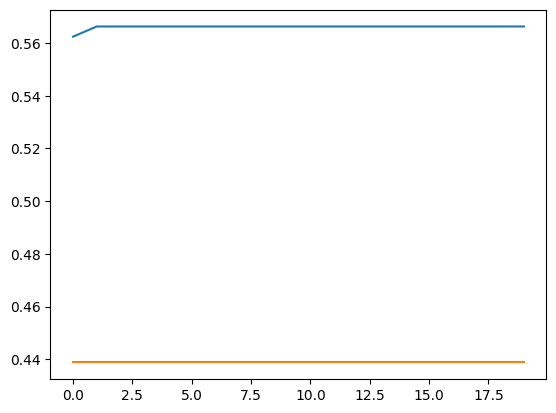

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

##Create testing batches

In [ ]:
testing_batches = []

for i in range(30,len(testing_data)):
    buffer_array = list(testing_data[i-30:i])
    if testing_data[i] > testing_data[i-1]:
        buffer_array.append(1)
    else:
        buffer_array.append(-1)

    testing_batches.append(buffer_array)
print(np.array(testing_batches).shape)

(547, 31)


In [ ]:
#Define batch scaling function
scaled_testing_data = []

# scaling_dict = {}
# def inverse_scale(x, min_x, max_x):
#   print("Inside inverse scale", x, min_x, max_x)
#   orig_seq = []
#   for j in x:
#     orig_j = j*(max_x-min_x) + min_x
#     orig_seq.append(orig_j)
#   return orig_seq

def scale(x, i):
  seq_x = list(x[:-1])
  max_x = max(seq_x)
  min_x = min(seq_x)
  # scaling_dict[i] = (min_x, max_x)
  new_seq = []
  for j in seq_x:
    new_j = (j-min_x)/(max_x-min_x)
    new_seq.append(new_j)
  new_seq.append(x[-1])
  return new_seq

for i in range(0, len(testing_batches)):
  seq = testing_batches[i]
  new_seq = scale(seq, i)
  scaled_testing_data.append(new_seq)

In [ ]:
np.array(scaled_testing_data).shape

(547, 31)

In [ ]:
np.array(scaled_testing_data).shape

x_test = []
y_test = []
for i in range(0, len(scaled_testing_data)):
    seq = scaled_testing_data[i]
    x_test.append(seq[0:-1])
    y_test.append(seq[-1])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_test.shape, y_test.shape)

(547, 30, 1) (547,)


In [ ]:
preds = model.predict(x_test)

18/18 [==============================] - 1s 11ms/step


In [ ]:
predictions = []

for i in preds:
  if i <= 0.50:
    predictions.append(1)
  else:
    predictions.append(0)


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

print(confusion_matrix(predictions, y_test))
print(accuracy_score(predictions, y_test))

[[  0   0]
 [252 295]]
0.5393053016453382
